<a href="https://colab.research.google.com/github/123gamal/Python_Practice/blob/main/teeth_classifictaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset"

train_dir = os.path.join(dataset_path, "Training")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Testing")

valid_classes = ["Gum", "OT", "OLP", "MC", "OC", "CaS", "CoS"]


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=valid_classes
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=valid_classes
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=valid_classes,
    shuffle=False
)


print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples:", test_gen.samples)


Mounted at /content/drive
Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Train samples: 3087
Validation samples: 1028
Test samples: 1028


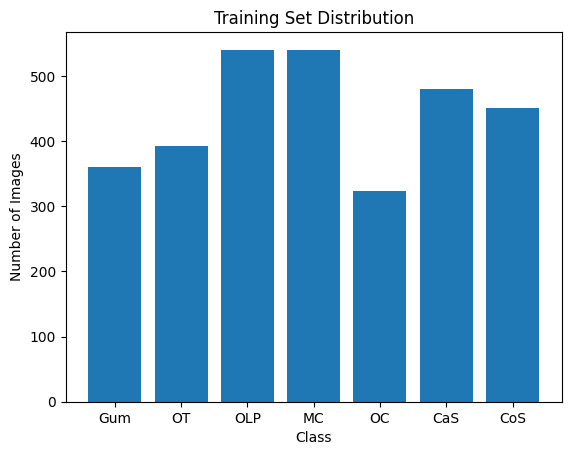

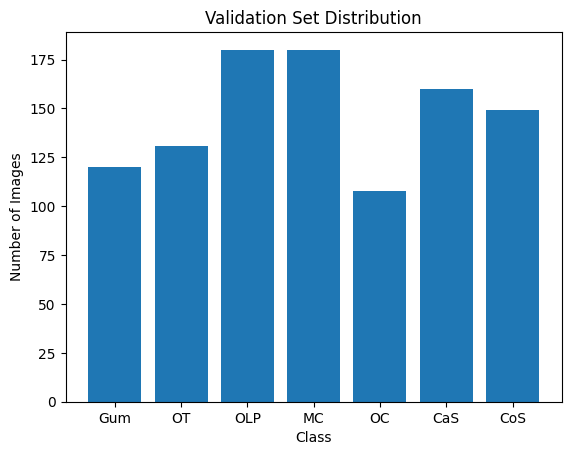

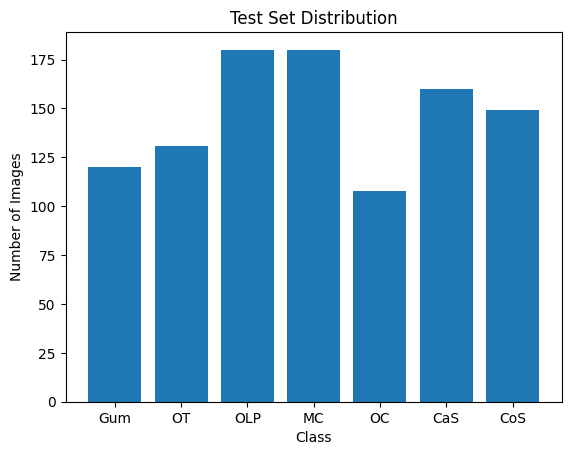

In [2]:
def plot_class_distribution(generator, title):
    counts = generator.classes
    class_names = list(generator.class_indices.keys())
    class_counts = [np.sum(counts == i) for i in range(len(class_names))]

    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(train_gen, "Training Set Distribution")
plot_class_distribution(val_gen, "Validation Set Distribution")
plot_class_distribution(test_gen, "Test Set Distribution")

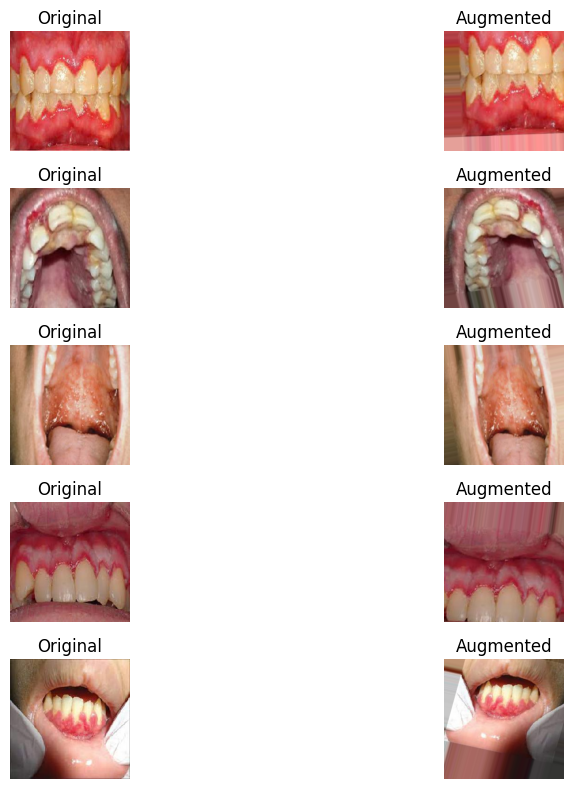

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

class_folder = os.path.join(train_dir, valid_classes[0])  # e.g., "Gum"
image_paths = [os.path.join(class_folder, fname) for fname in os.listdir(class_folder)][:5]

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

plt.figure(figsize=(12, 8))

for i, img_path in enumerate(image_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    plt.subplot(5, 2, i*2+1)
    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    plt.title("Original")

    aug_iter = train_datagen.flow(img_array_expanded, batch_size=1)
    aug_img = next(aug_iter)[0]

    plt.subplot(5, 2, i*2+2)
    plt.imshow(np.clip(aug_img, 0, 1))
    plt.axis("off")
    plt.title("Augmented")

plt.tight_layout()
plt.show()


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

tf.random.set_seed(42)

Class Weights: {0: np.float64(1.225), 1: np.float64(1.1221374045801527), 2: np.float64(0.8166666666666667), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.91875), 6: np.float64(0.98)}


In [5]:
from tensorflow.keras import layers, models, optimizers

model_2 = models.Sequential([
    layers.Input(shape=(224,224,3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(valid_classes), activation='softmax')
])

model_2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_2.summary()


history_2 = model_2.fit(train_gen,
                        epochs=20,
                        steps_per_epoch=len(train_gen),
                        validation_data=val_gen,
                        validation_steps=len(val_gen),
                        class_weight=class_weights)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,981,991 (99.11 MB)

 Trainable params: 25,980,583 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1427s 14s/step - accuracy: 0.2566 - loss: 2.3123 - val_accuracy: 0.1449 - val_loss: 24.1245
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 537ms/step - accuracy: 0.2890 - loss: 2.0339 - val_accuracy: 0.1449 - val_loss: 5.6739
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - accuracy: 0.3159 - loss: 2.1146 - val_accuracy: 0.1449 - val_loss: 10.5829
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 551ms/step - accuracy: 0.3723 - loss: 1.7872 - val_accuracy: 0.1547 - val_loss: 4.9368
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.4138 - loss: 1.6466 - val_accuracy: 0.2763 - val_loss: 3.3374
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.4210 - loss: 1.5926 - val_accuracy: 0.2568 - val_loss: 3.2737
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 534ms/step - accuracy: 0.4358 - loss: 1.4959 - val_accuracy: 0.5272 - val_loss: 1.3024
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.5035 - loss: 1.3363 - val_ac

In [6]:
model_2.evaluate(test_gen)

33/33 ━━━━━━━━━━━━━━━━━━━━ 371s 12s/step - accuracy: 0.6533 - loss: 1.1766


[0.9964056015014648, 0.6906614899635315]

In [7]:
model_3 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(valid_classes), activation='softmax')
])

model_3.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_3.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_3 = model_3.fit(train_gen,
                        epochs=50,
                        steps_per_epoch=len(train_gen),
                        validation_data=val_gen,
                        validation_steps=len(val_gen),
                        class_weight=class_weights,
                        callbacks = early_stop
                        )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,271 (42.62 MB)

 Trainable params: 11,170,567 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 613ms/step - accuracy: 0.2175 - loss: 2.4615 - val_accuracy: 0.1449 - val_loss: 22.8168
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.3005 - loss: 1.9956 - val_accuracy: 0.1449 - val_loss: 3.9398
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.3548 - loss: 1.7771 - val_accuracy: 0.1449 - val_loss: 4.8592
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.3978 - loss: 1.6800 - val_accuracy: 0.1566 - val_loss: 4.9063
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 527ms/step - accuracy: 0.4376 - loss: 1.5591 - val_accuracy: 0.1907 - val_loss: 4.4252
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.4767 - loss: 1.4169 - val_accuracy: 0.2675 - val_loss: 3.4312
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 504ms/step - accuracy: 0.4762 - loss: 1.3828 - val_accuracy: 0.3862 - val_loss: 2.1746
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 515ms/step - accuracy: 0.4919 - loss: 1.3696 - val_acc

In [8]:
model_3.evaluate(test_gen)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7733 - loss: 0.6352


[0.6612089276313782, 0.7616731524467468]